In [30]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
x = [19, 20, 21, 22, 22, 23, 24, 25, 26, 27, 29, 30, 35, 40, 50, 60, 63, 64, 68]
y = [510, 580, 560, 480, 500, 490, 570, 520, 480, 410, 430, 420, 390, 450, 380, 330, 410, 420, 430]
x = np.array(x, dtype=float)
y = np.array(y, dtype=float)

In [17]:
with pm.Model() as model:
    a = pm.Normal("a", mu=0.0, sigma=50.0)          # intercept on y-scale
    b = pm.Normal("b", mu=0.0, sigma=50.0)          # slope w.r.t. standardized x
    sigma = pm.HalfNormal("sigma", sigma=20.0)      # noise SD (must be > 0)

    mu = a + b * x
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

    # MCMC sampling (NUTS)
    idata = pm.sample(
        draws=2000,
        tune=2000,
        chains=4,
        target_accept=0.9,
        random_seed=42
    )

    # Posterior predictive samples (for predictions / checks)
    ppc = pm.sample_posterior_predictive(idata, var_names=["y_obs", "a", "b", "sigma"], random_seed=42)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.
/opt/anaconda3/envs/pylfire1_env/lib/python3.8/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
Sampling: [a, b, sigma, y_obs]


          mean      sd   hdi_3%  hdi_97%
a      295.464  53.166  200.317  398.041
b        3.363   1.346    0.761    5.721
sigma   88.299  12.765   64.362  112.058


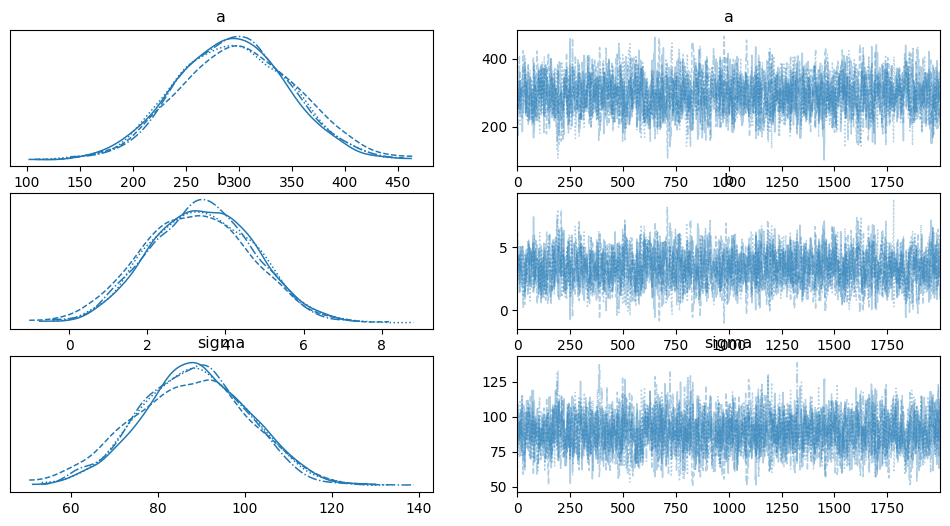

In [20]:
print(az.summary(idata, var_names=["a", "b", "sigma"], kind="stats"))
az.plot_trace(idata, var_names=["a", "b", "sigma"])
plt.show()

In [23]:
# -----------------------
# Predict distance for a new age (with uncertainty)
# -----------------------
ew_age = 45.0

a_post = idata.posterior["a"].values.reshape(-1)      # (n_samples,)
b_post = idata.posterior["b"].values.reshape(-1)      # (n_samples,)
sigma_post = idata.posterior["sigma"].values.reshape(-1)

pred_mean = a_post + b_post * new_age                 # (n_samples,)

# posterior predictive (adds observation noise)
pred_y = np.random.normal(loc=pred_mean, scale=sigma_post)

print(f"Prediction for age={new_age}:")
print("Posterior predictive mean:", pred_y.mean())
print("95% predictive interval:", np.quantile(pred_y, [0.025, 0.975]))
print("95% mean (noise-free) interval:", np.quantile(pred_mean, [0.025, 0.975]))

Prediction for age=45.0:
Posterior predictive mean: 446.50804393919924
95% predictive interval: [265.67435313 632.80279631]
95% mean (noise-free) interval: [398.81482714 495.52875277]


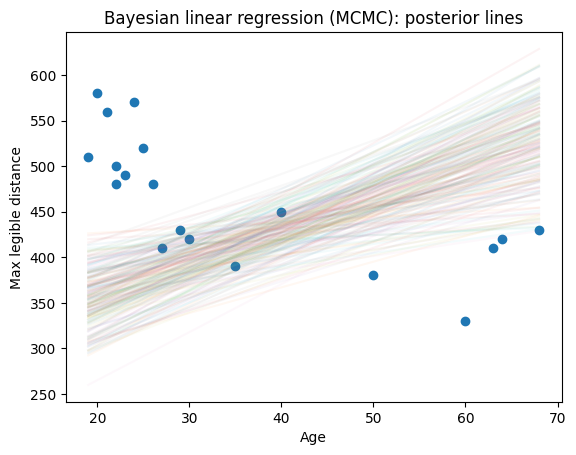

In [27]:
# -----------------------
# Plot data + posterior regression lines
# -----------------------
# Posterior samples
a_post = idata.posterior["a"].values.reshape(-1)
b_post = idata.posterior["b"].values.reshape(-1)

x_grid = np.linspace(x.min(), x.max(), 100)

# choose up to 200 posterior draws
idx = np.random.choice(a_post.size, size=min(200, a_post.size), replace=False)

plt.scatter(x, y, label="Observed data")

for i in idx:
    plt.plot(x_grid, a_post[i] + b_post[i] * x_grid, alpha=0.05)

plt.xlabel("Age")
plt.ylabel("Max legible distance")
plt.title("Bayesian linear regression (MCMC): posterior lines")
plt.show()

In [29]:
import numpy as np

x = np.asarray(x, dtype=float)   # age
y = np.asarray(y, dtype=float)   # distance

# Correlation (should be negative if distance decreases with age)
corr = np.corrcoef(x, y)[0, 1]
print("corr(age, distance) =", corr)

# Ordinary least squares slope and intercept for y = a + b x
xbar, ybar = x.mean(), y.mean()
b_ols = np.sum((x - xbar) * (y - ybar)) / np.sum((x - xbar)**2)
a_ols = ybar - b_ols * xbar
print("OLS intercept =", a_ols)
print("OLS slope     =", b_ols)


corr(age, distance) = -0.6901137433986498
OLS intercept = 558.9137068228976
OLS slope     = -2.783473697058464


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.
Sampling: [a, b, sigma, y_obs]


          mean      sd   hdi_3%  hdi_97%
a      437.079  13.611  410.729  460.979
b      -44.725  11.708  -66.340  -23.003
sigma   50.715   7.944   37.536   66.173


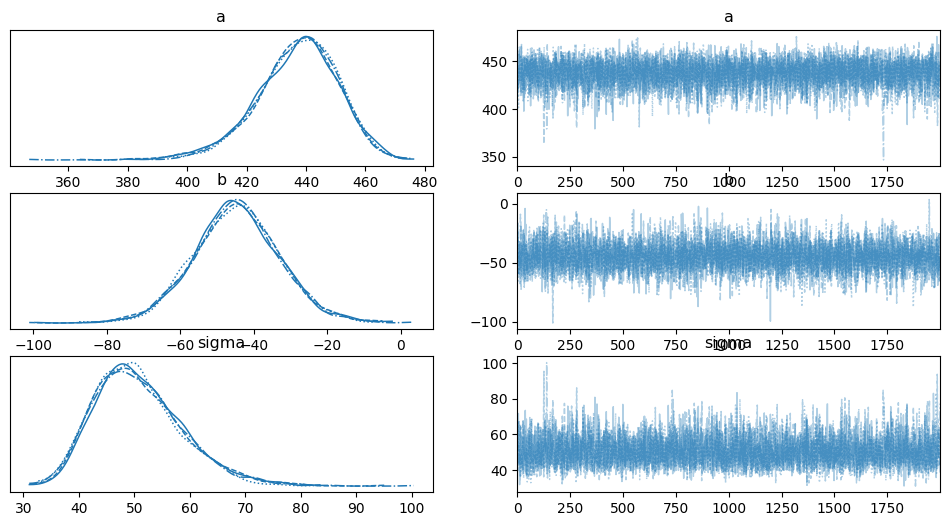

In [31]:
# -----------------------
# (Optional but recommended) standardize x for easier sampling
# Then convert parameters back to original scale.
# -----------------------
x_mean, x_std = x.mean(), x.std(ddof=1)
x_s = (x - x_mean) / x_std

# -----------------------
# Bayesian model
# y = a + b * x + eps, eps ~ Normal(0, sigma)
# -----------------------
with pm.Model() as model:
    a = pm.Normal("a", mu=0.0, sigma=50.0)          # intercept on y-scale
    b = pm.Normal("b", mu=0.0, sigma=50.0)          # slope w.r.t. standardized x
    sigma = pm.HalfNormal("sigma", sigma=20.0)      # noise SD (must be > 0)

    mu = a + b * x_s
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

    # MCMC sampling (NUTS)
    idata = pm.sample(
        draws=2000,
        tune=2000,
        chains=4,
        target_accept=0.9,
        random_seed=42
    )

    # Posterior predictive samples (for predictions / checks)
    ppc = pm.sample_posterior_predictive(idata, var_names=["y_obs", "a", "b", "sigma"], random_seed=42)

# -----------------------
# Diagnostics / summary
# -----------------------
print(az.summary(idata, var_names=["a", "b", "sigma"], kind="stats"))
az.plot_trace(idata, var_names=["a", "b", "sigma"])
plt.show()

In [32]:
# -----------------------
# Convert slope/intercept back to ORIGINAL x scale
# If model used x_s = (x - mean)/std:
# y = a + b*(x-mean)/std = (a - b*mean/std) + (b/std)*x
# -----------------------
a_post = idata.posterior["a"].values.reshape(-1)
b_post = idata.posterior["b"].values.reshape(-1)

intercept_orig = a_post - b_post * (x_mean / x_std)
slope_orig = b_post / x_std

print("\nPosterior mean (original scale):")
print("Intercept:", intercept_orig.mean())
print("Slope:", slope_orig.mean())


Posterior mean (original scale):
Intercept: 529.820750245409
Slope: -2.6378693052170736



Prediction for age=45.0:
Posterior predictive mean: 411.1906879649216
95% predictive interval: [300.66571246 515.04786294]


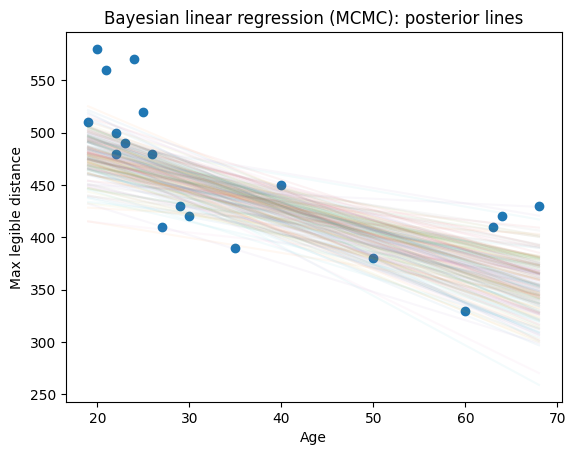

In [33]:
# -----------------------
# Predict distance for a new age (with uncertainty)
# -----------------------
new_age = 45.0
pred_mean = intercept_orig + slope_orig * new_age

# Add observation noise for predictive distribution:
sigma_post = idata.posterior["sigma"].values.reshape(-1)
pred_y = np.random.normal(loc=pred_mean, scale=sigma_post)

print(f"\nPrediction for age={new_age}:")
print("Posterior predictive mean:", pred_y.mean())
print("95% predictive interval:", np.quantile(pred_y, [0.025, 0.975]))

# -----------------------
# Plot data + posterior regression lines
# -----------------------
x_grid = np.linspace(x.min(), x.max(), 100)
# draw a subset of posterior lines for visualization
idx = np.random.choice(intercept_orig.size, size=min(200, intercept_orig.size), replace=False)

plt.scatter(x, y, label="Observed data")
for i in idx:
    plt.plot(x_grid, intercept_orig[i] + slope_orig[i] * x_grid, alpha=0.05)

plt.xlabel("Age")
plt.ylabel("Max legible distance")
plt.title("Bayesian linear regression (MCMC): posterior lines")
plt.show()

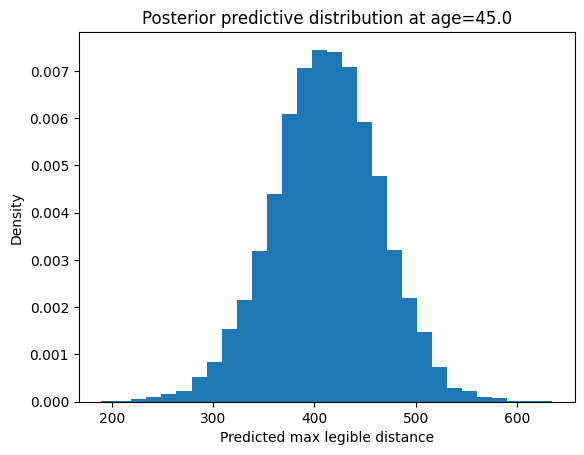

Predictive mean: 411.4920753800335
95% predictive interval: [303.59001461 513.15142639]


In [34]:
new_age = 45.0
new_age_s = (new_age - x_mean) / x_std

a_post = idata.posterior["a"].values.reshape(-1)
b_post = idata.posterior["b"].values.reshape(-1)
sigma_post = idata.posterior["sigma"].values.reshape(-1)

mu_new = a_post + b_post * new_age_s
y_new = np.random.normal(loc=mu_new, scale=sigma_post)

plt.hist(y_new, bins=30, density=True)
plt.xlabel("Predicted max legible distance")
plt.ylabel("Density")
plt.title(f"Posterior predictive distribution at age={new_age}")
plt.show()

print("Predictive mean:", y_new.mean())
print("95% predictive interval:", np.quantile(y_new, [0.025, 0.975]))

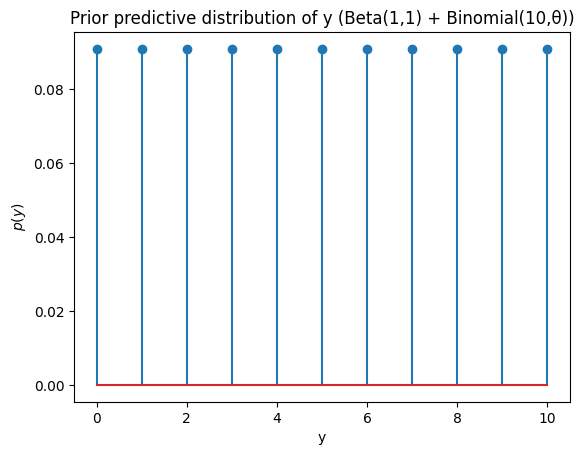

In [35]:
import numpy as np
import matplotlib.pyplot as plt

n = 10
ys = np.arange(n + 1)

prior_pred = np.ones(n + 1) / (n + 1)  # uniform for Beta(1,1)

plt.figure()
plt.stem(ys, prior_pred)
plt.xlabel("y")
plt.ylabel(r"$p(y)$")
plt.title("Prior predictive distribution of y (Beta(1,1) + Binomial(10,θ))")
plt.show()

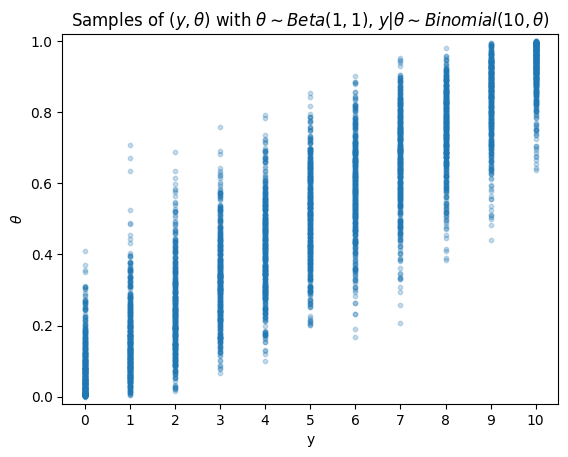

In [38]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)
n = 10
M = 5000

theta = rng.beta(1, 1, size=M)          # θ ~ Beta(1,1)
y = rng.binomial(n=n, p=theta)          # y | θ

plt.scatter(y, theta, s=10, alpha=0.25)
plt.xlabel("y")
plt.ylabel(r"$\theta$")
plt.title(r"Samples of $(y,\theta)$ with $\theta\sim Beta(1,1)$, $y|\theta\sim Binomial(10,\theta)$")
plt.xticks(range(n + 1))
plt.ylim(-0.02, 1.02)
plt.show()


In [39]:
from scipy.stats import beta

a_post, b_post = 5, 7  # Beta(5,7)

mean = beta.mean(a_post, b_post)
ci = beta.ppf([0.025, 0.975], a_post, b_post)
p_gt_05 = 1 - beta.cdf(0.5, a_post, b_post)

print("Posterior: Beta(5,7)")
print("Mean:", mean)
print("95% CI:", ci)
print("P(theta > 0.5):", p_gt_05)


Posterior: Beta(5,7)
Mean: 0.4166666666666667
95% CI: [0.16748809 0.69209528]
P(theta > 0.5): 0.2744140625


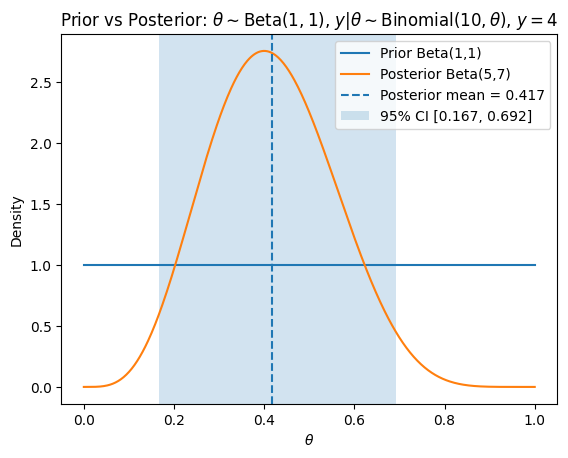

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# Prior and posterior
a0, b0 = 1, 1          # Beta(1,1)
a1, b1 = 5, 7          # Beta(5,7) from y=4, n=10

theta = np.linspace(0, 1, 500)

prior_pdf = beta.pdf(theta, a0, b0)
post_pdf  = beta.pdf(theta, a1, b1)

# Posterior summaries
post_mean = beta.mean(a1, b1)
ci_lo, ci_hi = beta.ppf([0.025, 0.975], a1, b1)

plt.plot(theta, prior_pdf, label="Prior Beta(1,1)")
plt.plot(theta, post_pdf,  label="Posterior Beta(5,7)")

plt.axvline(post_mean, linestyle="--", label=f"Posterior mean = {post_mean:.3f}")
plt.axvspan(ci_lo, ci_hi, alpha=0.2, label=f"95% CI [{ci_lo:.3f}, {ci_hi:.3f}]")

plt.xlabel(r"$\theta$")
plt.ylabel("Density")
plt.title(r"Prior vs Posterior: $\theta \sim \mathrm{Beta}(1,1)$, $y| \theta \sim \mathrm{Binomial}(10,\theta)$, $y=4$")
plt.legend()
plt.show()


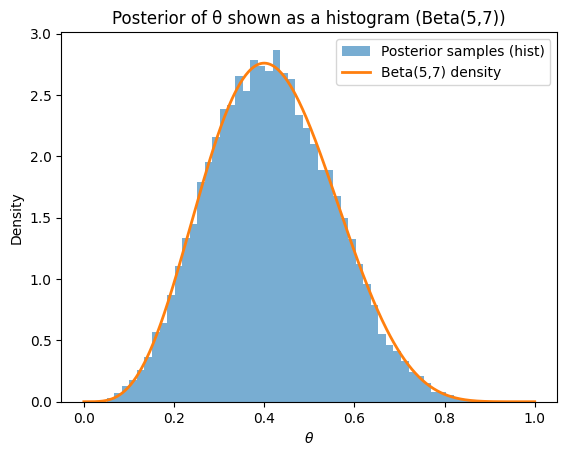

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

rng = np.random.default_rng(42)

# Posterior Beta(5,7)
a_post, b_post = 5, 7

# Sample from posterior
M = 20000
theta_samps = rng.beta(a_post, b_post, size=M)

# Histogram (density=True makes it comparable to a PDF)
plt.hist(theta_samps, bins=50, density=True, alpha=0.6, label="Posterior samples (hist)")

# Optional: overlay the exact posterior density
theta = np.linspace(0, 1, 500)
plt.plot(theta, beta.pdf(theta, a_post, b_post), linewidth=2, label="Beta(5,7) density")

plt.xlabel(r"$\theta$")
plt.ylabel("Density")
plt.title("Posterior of θ shown as a histogram (Beta(5,7))")
plt.legend()
plt.show()


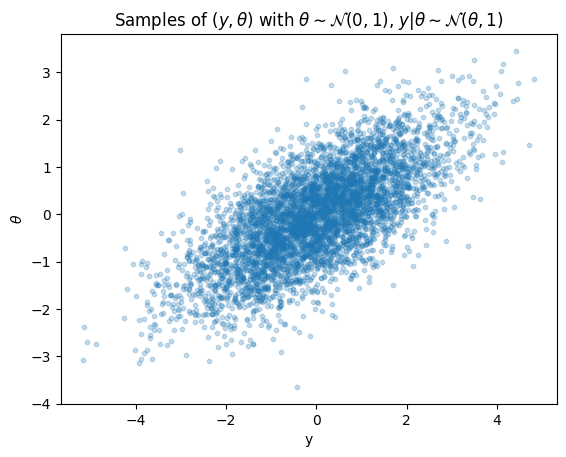

In [49]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)
M = 5000

theta = rng.normal(0, 1, size=M)      # θ ~ Normal(0,1)
y = rng.normal(loc=theta, scale=1.0)  # y | θ ~ Normal(θ,1)

plt.scatter(y, theta, s=10, alpha=0.25)
plt.xlabel("y")
plt.ylabel(r"$\theta$")
plt.title(r"Samples of $(y,\theta)$ with $\theta\sim \mathcal{N}(0,1)$, $y|\theta\sim \mathcal{N}(\theta,1)$")
plt.show()


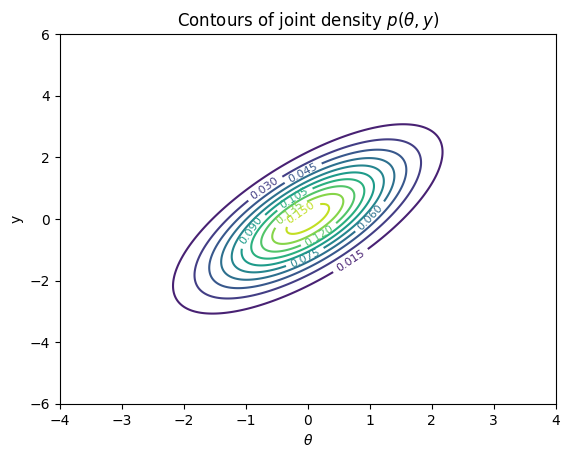

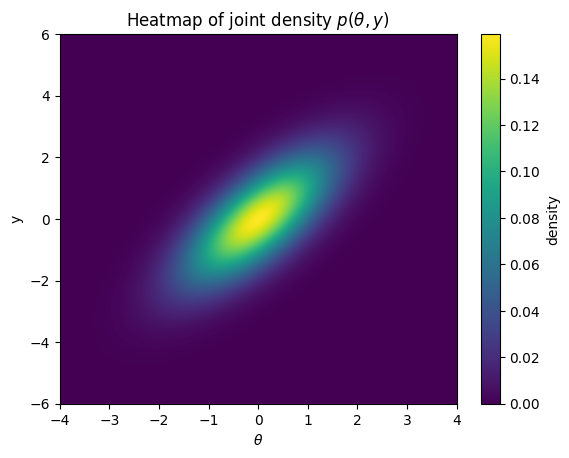

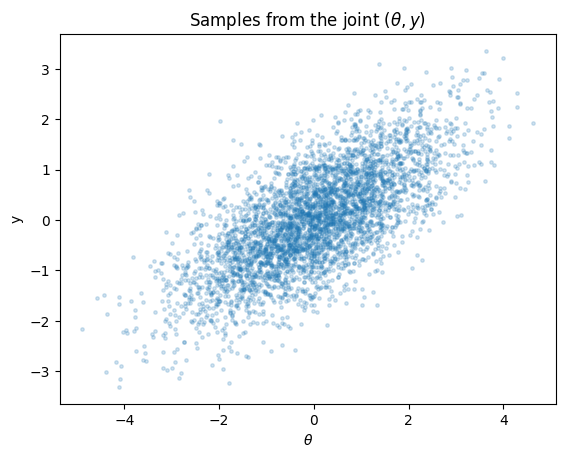

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Joint: (theta, y) ~ N([0,0], [[1,1],[1,2]])
mu = np.array([0.0, 0.0])
Sigma = np.array([[1.0, 1.0],
                  [1.0, 2.0]])

# --- make a grid over (theta, y) ---
theta_grid = np.linspace(-4, 4, 301)
y_grid     = np.linspace(-6, 6, 361)
T, Y = np.meshgrid(theta_grid, y_grid)          # T=theta, Y=y
X = np.stack([T, Y], axis=-1)                   # shape (ny, ntheta, 2)

# --- bivariate normal pdf computed manually (no SciPy needed) ---
invS = np.linalg.inv(Sigma)
detS = np.linalg.det(Sigma)
norm_const = 1.0 / (2.0 * np.pi * np.sqrt(detS))

d = X - mu
quad = np.einsum("...i,ij,...j->...", d, invS, d)   # (x-mu)^T invS (x-mu)
Z = norm_const * np.exp(-0.5 * quad)                # joint density p(theta, y)

# --- Plot 1: contour plot of the joint density ---
plt.figure()
cs = plt.contour(T, Y, Z, levels=12)
plt.clabel(cs, inline=True, fontsize=8)
plt.xlabel(r"$\theta$")
plt.ylabel("y")
plt.title(r"Contours of joint density $p(\theta, y)$")
plt.show()

# --- Plot 2 (optional): heatmap of the joint density ---
plt.figure()
plt.imshow(
    Z,
    origin="lower",
    aspect="auto",
    extent=[theta_grid.min(), theta_grid.max(), y_grid.min(), y_grid.max()],
)
plt.xlabel(r"$\theta$")
plt.ylabel("y")
plt.title(r"Heatmap of joint density $p(\theta, y)$")
plt.colorbar(label="density")
plt.show()

# --- Plot 3 (optional): sample points to see the dependence/correlation ---
rng = np.random.default_rng(42)
samples = rng.multivariate_normal(mean=mu, cov=Sigma, size=4000)
theta_s = samples[:, 0]
y_s     = samples[:, 1]

plt.figure()
plt.scatter(y_s,theta_s, s=6, alpha=0.2)
plt.xlabel(r"$\theta$")
plt.ylabel("y")
plt.title(r"Samples from the joint $(\theta, y)$")
plt.show()
